<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GradCam
参考： https://github.com/eclique/pytorch-gradcam

In [0]:
import argparse
import cv2
import numpy as np
import torch
from torch.autograd import Function
from torch import nn
from torchvision import models, transforms

import os
from matplotlib import pyplot as plt
from PIL import Image

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Opens image from disk, normalizes it and converts to tensor
read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    lambda x: torch.unsqueeze(x, 0) #次元を1に引き延ばす
])

In [0]:
class Flatten(nn.Module): 
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

In [0]:
# Given label number returns class name
def get_class_name(c):
    labels = np.loadtxt('/content/drive/My Drive/Deep_learning/applstra/synset_words.txt', str, delimiter='\t')
    return ' '.join(labels[c].split(',')[0].split()[1:])



#Load model
Here, model is split into two parts: feature extractor and classifier. Provided is the implementation for ResNet/VGG/DenseNet architechtures.

Here, Flatten layer is being built in in the model as well. In PyTorch implementation flattenning is done in the forward pass, but we need it as a separate layer.

In [0]:
#model = models.vgg19(pretrained=True)
model = models.resnet50(pretrained=True)
#model = models.densenet201(pretrained=True)

# Split model in two parts
arch = model.__class__.__name__
if arch == 'ResNet':
    features_fn = nn.Sequential(*list(model.children())[:-2]) #最後の2層（AdaptiveAvgPool2dとLinear)を取り除いたもの
    classifier_fn = nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:])) #最終層の前にFlatten()を挿入
elif arch == 'VGG':
    features_fn = nn.Sequential(*list(model.features.children())[:-1])
    classifier_fn = nn.Sequential(*(list(model.features.children())[-1:] + [Flatten()] + list(model.classifier.children())))
elif arch == 'DenseNet':
    features_fn = model.features
    classifier_fn = nn.Sequential(*([nn.AvgPool2d(7, 1), Flatten()] + [model.classifier]))
    
model = model.eval()
model = model.cuda()

In [0]:
#ネットワークの確認
from torchsummary import summary

features_fn = features_fn.cuda()
summary(features_fn, (3,224,224))

In [54]:
print(classifier_fn)

Sequential(
  (0): AdaptiveAvgPool2d(output_size=(1, 1))
  (1): Flatten()
  (2): Linear(in_features=2048, out_features=1000, bias=True)
)


#GradCam

In [0]:
def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda())
    _, N, H, W = feats.size() #[1,2048,7,7]
    out = classifier_fn(feats) #out: [1,1000]
    c_score = out[0, c]

    #print(c_score)

    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)           #ここでGlobalAveragePoolingをしている
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0) #ReLUと同じ
    return sal

#Example

tensor(15.1943, device='cuda:0', grad_fn=<SelectBackward>)
tensor(11.1446, device='cuda:0', grad_fn=<SelectBackward>)
tensor(10.6133, device='cuda:0', grad_fn=<SelectBackward>)


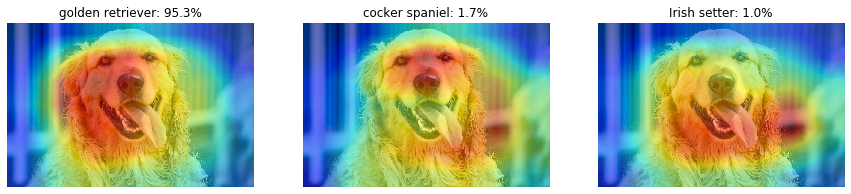

In [64]:
mg_path = '/content/drive/My Drive/AI_laboratory_course/goldenretriever-3724972_640.jpg'
img_tensor = read_tensor(img_path)
#Softmaxにかけたときの確率上位3つのpp(確率)とcc(class番号)を取得
pp, cc = torch.topk(nn.Softmax(dim=1)(model(img_tensor.cuda())), 3)

plt.figure(figsize=(15, 5))
#pとcを対にして入力
for i, (p, c) in enumerate(zip(pp[0], cc[0])):
    #グラフを1行3列に並べたうちのi番目
    plt.subplot(1, 3, i+1)
    sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
    img = Image.open(img_path)
    #TensorをImageに変換
    sal = Image.fromarray(sal)
    sal = sal.resize(img.size, resample=Image.LINEAR)

    #plt.title('')
    plt.title('{}: {:.1f}%'.format(get_class_name(c), 100*float(p)))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(np.array(sal), alpha=0.5, cmap='jet')
plt.show()